# Load libraries and set the coordinate system

In [1]:
%pylab inline

import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from PIL import Image

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

"""
Set up the domain and the grid
"""

im = Image.open('annulusmask.tif')
imarray = np.array(im)

x_obs_positions = np.arange(320)
y_obs_positions = np.arange(240)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

coords = [[ [x,y] for x in x_obs_positions] for y in y_obs_positions] 
coords = np.array([item for sublist in coords for item in sublist])
distances = ((coords[:,0]-N/2.)**2 + (coords[:,1]-M/2.)**2)**0.5
angles = np.arctan2(coords[:,1]-N/2.,coords[:,0]-M/2.)

a = 45
b = 50 # stress support
c = 15 # cell boundary

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Populating the interactive namespace from numpy and matplotlib


# Generate the stress field

In [2]:
CUTOFF  = 10

fr = 1e-4
ftheta = 1e-4

m = 3
n = 4

condition_outside = (imarray.reshape((320*240,)) != 0 ) * (distances <= b + CUTOFF)
condition_inside = (imarray.reshape((320*240,)) == 0 ) * (distances >= a - CUTOFF)

stress_r = 0 + (distances>=a) * (distances<=b) * fr * np.sin(m*angles)
stress_theta = 0 + (distances>=a) * (distances<=b) * ftheta * np.cos(n*angles)

stress_x = stress_r*cos(angles) -stress_theta*sin(angles)
stress_y = stress_r*sin(angles) + stress_theta*cos(angles)

s_x = stress_x[condition_inside]
s_y = stress_y[condition_inside]

# build the stress field

x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)



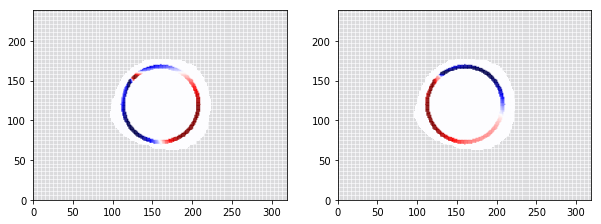

In [3]:
fig = plt.figure(figsize=(10,6))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((M,N)),
                           cmap='seismic_r',vmax = 1e-4, vmin=-1e-4, alpha = 0.4).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')

plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((M,N)),
                           cmap='seismic_r',vmax = 1e-4, vmin=-1e-4, alpha = 0.4).axes.set_aspect('equal')

In [4]:
sum((coords[:,0]-N/2)*stress_y - (coords[:,1]-M/2)*stress_x)

1.8370364882535195

# Generate linear system matrices

In [5]:
G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = False)

Size of the problem is 8200


KeyboardInterrupt: 

In [ ]:
# Generate the measured dispalcements

u_in_x = G_in_in_xx.dot(s_x) + G_in_in_xy.dot(s_y)
u_out_x = G_out_in_xx.dot(s_x) + G_out_in_xy.dot(s_y)

u_in_y = G_in_in_yx.dot(s_x) + G_in_in_yy.dot(s_y)
u_out_y = G_out_in_yx.dot(s_x)  + G_out_in_yy.dot(s_y)

u_x = np.zeros(coords.shape[0])
u_x[condition_inside] = u_in_x
u_x[condition_outside] = u_out_x

u_y = np.zeros(coords.shape[0])
u_y[condition_inside] = u_in_y
u_y[condition_outside] = u_out_y


In [ ]:
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


# Coords are 1:100 in each direction
# annulus centered
# inner radius 20
# outer radius 30
# boundary radius 35

gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in_x = G_in_in_xx * sigma_xz + G_in_in_xy * sigma_yz
predicted_out_x = G_out_in_xx * sigma_xz + G_out_in_xy * sigma_yz
predicted_in_y = G_in_in_yx * sigma_xz + G_in_in_yy * sigma_yz
predicted_out_y = G_out_in_yx * sigma_xz + G_out_in_yy * sigma_yz


error = sum_squares(u_in_x - predicted_in_x) + sum_squares(u_out_x - predicted_out_x) + \
    sum_squares(u_in_y - predicted_in_y) + sum_squares(u_out_y - predicted_out_y)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []

In [ ]:
regularity_penalty = norm(sigma_xz+sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []
u_y_values = []

In [ ]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside] = sigma_xz.value.reshape((n_in,))
    s_y[condition_inside] = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside] = predicted_in_x.value
    u_x[condition_outside] = predicted_out_x.value
    u_y[condition_inside] = predicted_in_y.value
    u_y[condition_outside] = predicted_out_y.value

    return np.array([s_x, s_y]).T, np.array([u_x, u_y]).T, error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)


In [ ]:
force, u, err, reg, val = invert_one(gamma_vals[-1])

In [ ]:
maxval = np.max(np.abs(force))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval,vmax=maxval).axes.set_aspect('equal')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,0].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval,vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

In [ ]:
plt.subplot(121)

maxval = np.max(np.abs(stress_y))
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,1].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

In [ ]:
maxval = np.max(np.abs(u_x))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,u_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,0].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

In [ ]:
maxval = np.max(np.abs(u_y))

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,u_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,1].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmin=-maxval, vmax=maxval).axes.set_aspect('equal')
#plt.colorbar()

In [ ]:
sum(force)